Лабораторная 7

Информация о диабете индейцев Пима

In [7]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl

df = pd.read_csv(".//scv//diabetes.csv")
print(df.columns)
df

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

Создаем лингвистические переменные

Входные: age(возраст) и bmi(ИМТ)

Выходные: glucose(давление)

In [8]:
age = ctrl.Antecedent(np.arange(df["Age"].min(), df["Age"].max() + 1, 1), "age")
bmi = ctrl.Antecedent(np.arange(df["BMI"].min(), df["BMI"].max() + 0.1, 0.1), "bmi")
glucose = ctrl.Consequent(np.arange(df["Glucose"].min(), df["Glucose"].max() + 0.1, 0.1), "glucose")

Настраиваем их

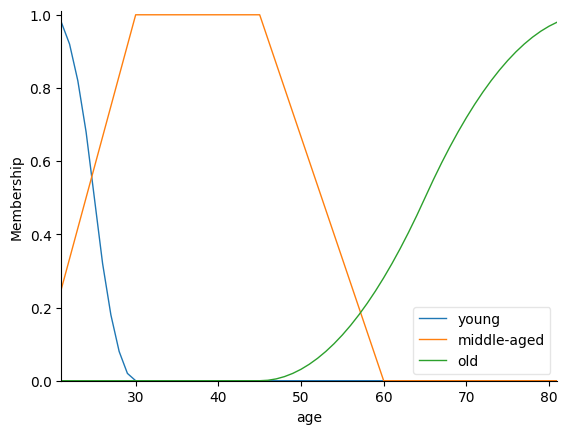

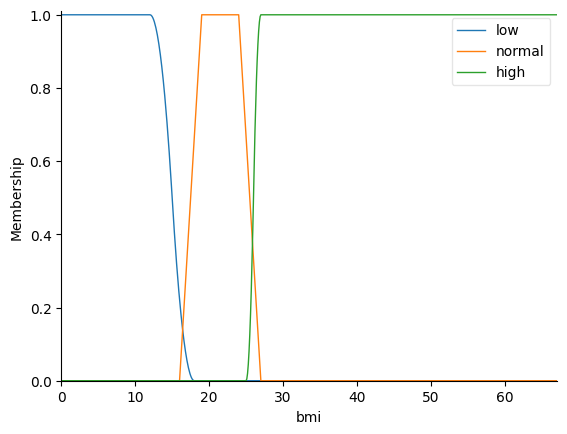

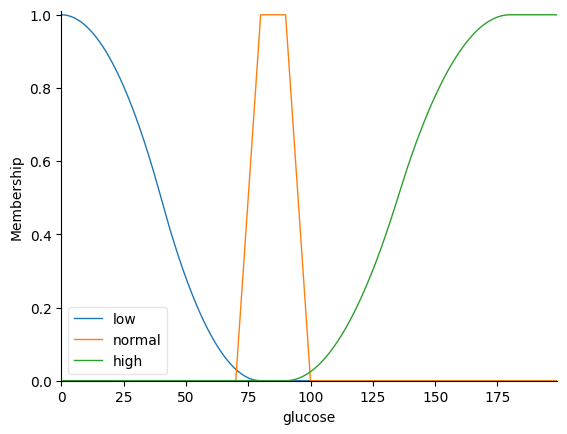

In [15]:
age["young"] = fuzz.zmf(age.universe, 20, 30)
age["middle-aged"] = fuzz.trapmf(age.universe, [18, 30, 45, 60])
age["old"] = fuzz.smf(age.universe, 45, 85)
age.view()


bmi["low"] = fuzz.zmf(bmi.universe, 12, 18)
bmi["normal"] = fuzz.trapmf(bmi.universe, [16, 19, 24, 27])
bmi["high"] = fuzz.smf(bmi.universe, 25, 27)
bmi.view()

glucose["low"] = fuzz.zmf(glucose.universe, 0, 80)
glucose["normal"] = fuzz.trapmf(glucose.universe, [70, 80, 90, 100])
glucose["high"] = fuzz.smf(glucose.universe, 90, 180)
glucose.view()

База нечетких правил:

(<Figure size 640x480 with 1 Axes>, <Axes: >)

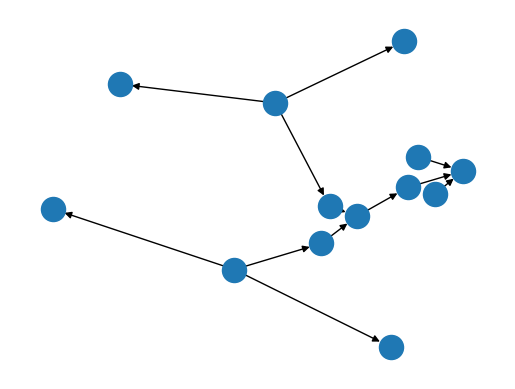

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

rule1 = ctrl.Rule(age["young"] & bmi["low"], glucose["low"])
rule2 = ctrl.Rule(age["young"] & bmi["normal"], glucose["normal"])
rule3 = ctrl.Rule(age["young"] & bmi["high"], glucose["normal"])

rule4 = ctrl.Rule(age["middle-aged"] & bmi["low"], glucose["normal"])
rule5 = ctrl.Rule(age["middle-aged"] & bmi["normal"], glucose["normal"])
rule6 = ctrl.Rule(age["middle-aged"] & bmi["high"], glucose["high"])

rule7 = ctrl.Rule(age["old"] & bmi["low"], glucose["low"])
rule8 = ctrl.Rule(age["old"] & bmi["normal"], glucose["normal"])
rule9 = ctrl.Rule(age["old"] & bmi["high"], glucose["high"])

rule1.view()

Создание нечеткой системы и добавление нечетких правил в базу знаний нечеткой системы

d:\5_semester\AIM\rep\AIM-PIbd-31-Razubaev-S-M\.venv\Lib\site-packages\skfuzzy\control\controlsystem.py:135: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


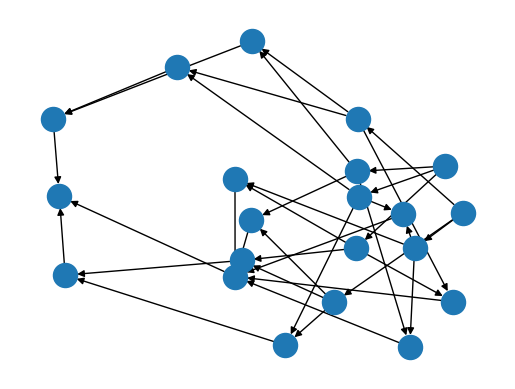

In [17]:
glucose_ctrl  = ctrl.ControlSystem(
    [
        rule1,
        rule2,
        rule3,
        rule4,
        rule5,
        rule6,
        rule7,
        rule8,
        rule9,
    ]
)

glucose_simulation = ctrl.ControlSystemSimulation(glucose_ctrl)

glucose_ctrl.view()

Проверка расчета выходной переменной

In [19]:
glucose_simulation.input["age"] = 31
glucose_simulation.input["bmi"] = 25
glucose_simulation.compute()

glucose_simulation.print_state()
glucose_simulation.output["glucose"]

 Antecedents 
Antecedent: age                     = 31
  - young                           : 0.0
  - middle-aged                     : 1.0
  - old                             : 0.0
Antecedent: bmi                     = 25
  - low                             : 0.0
  - normal                          : 0.6666666666666666
  - high                            : 0.0

 Rules 
RULE #0:
  IF age[young] AND bmi[low] THEN glucose[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - age[young]                                             : 0.0
  - bmi[low]                                               : 0.0
                                   age[young] AND bmi[low] = 0.0
  Activation (THEN-clause):
                                              glucose[low] : 0.0

RULE #1:
  IF age[young] AND bmi[normal] THEN glucose[normal]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - age[young]                   

np.float64(85.00000000000001)

Визуализации функции принадлежности

d:\5_semester\AIM\rep\AIM-PIbd-31-Razubaev-S-M\.venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


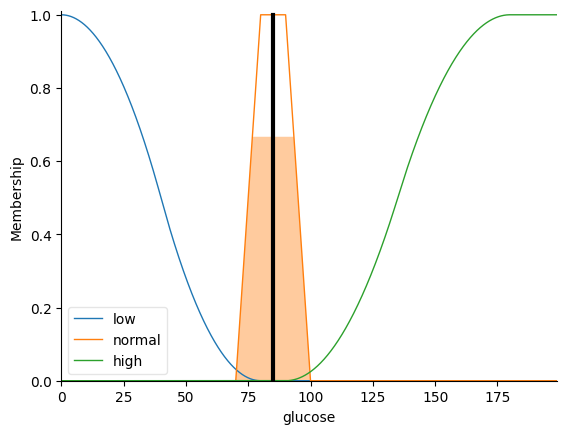

In [20]:
glucose.view(sim=glucose_simulation)

Оценка качества

In [25]:
def fuzzy_pred(row):
    glucose_simulation.input["age"] = row["Age"]
    glucose_simulation.input["bmi"] = row["BMI"]
    glucose_simulation.compute()
    return glucose_simulation.output["glucose"]

result = df.copy()

result["glucose_pred"] = result.apply(fuzzy_pred, axis=1)

result.loc[115:130, ["Age", "BMI", "Glucose", "glucose_pred"]]

Age   BMI  Glucose  glucose_pred
115   61  31.2      146    156.076444
116   38  34.0      124    164.363268
117   25  33.7       78    155.611863
118   22  28.2       97    142.749562
119   21  23.2       99     85.000000
120   25  53.2      162    155.611863
121   24  34.2      111    152.260658
122   23  33.6      107    148.066203
123   69  26.8      132    158.239802
124   23  33.3      113    148.066203
125   26  55.0       88    158.305050
126   30  42.9      120    164.363268
127   23  33.3      118    148.066203
128   40  34.5      117    164.363268
129   62  27.9      105    156.763261
130   33  29.7      173    164.363268

In [29]:
import math
from sklearn import metrics

rmetrics = {}
rmetrics["RMSE"] = math.sqrt(
    metrics.mean_squared_error(result["Glucose"], result["glucose_pred"])
)
rmetrics["RMAE"] = math.sqrt(
    metrics.mean_absolute_error(result["Glucose"], result["glucose_pred"])
)
rmetrics["R2"] = metrics.r2_score(
    result["Glucose"], result["glucose_pred"]
)
rmetrics

{'RMSE': 44.436073098835, 'RMAE': 6.078634343122391, 'R2': -0.9341083419845992}

Вывод: данные прогнозируются с низкой точностью и допускается множество ошибок